# ECG-Mamba Cardiac Abnormality Classification

This notebook implements a testing pipeline for ECG cardiac abnormality classification using the Mamba architecture.

**Note:** This notebook requires a GPU to run efficient Mamba implementations. Please ensure your Runtime type is set to **T4 GPU** (or better) in Google Colab.

In [14]:
# @title 1. Install Dependencies
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("Installing dependencies...")
install("wfdb")
install("pandas")
install("numpy")
install("scikit-learn")
install("matplotlib")
install("torch")
install("requests")

try:
    import mamba_ssm
except ImportError:
    print("Installing mamba-ssm and dependencies (this may take a minute)...")
    install("causal-conv1d>=1.2.0")
    install("mamba-ssm")

print("Dependencies installed.")

print("Dependencies installed.")

Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 192.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [wfdb]2m10/12 [aiohttp]


Dependencies installed.
Dependencies installed.


In [15]:
# @title 2. Download PTB-XL Subset (PhysioNet)
import os
import requests
import pandas as pd
import wfdb
import ast
import numpy as np

# Constants
BASE_URL = "https://physionet.org/files/ptb-xl/1.0.3/"
DATA_DIR = "ptb_xl_data"
NUM_RECORDS = 500  # Number of records to download for the small-scale test

os.makedirs(DATA_DIR, exist_ok=True)

def download_file(url, save_path):
    if os.path.exists(save_path):
        return
    try:
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(save_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    except Exception as e:
        print(f"Failed to download {url}: {e}")

# 1. Download Database CSV
print("Downloading database index...")
csv_path = os.path.join(DATA_DIR, "ptbxl_database.csv")
download_file(BASE_URL + "ptbxl_database.csv", csv_path)

# 2. Load and Sample
df = pd.read_csv(csv_path, index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Filter for records that have a label (NORM, MI, STTC, CD, HYP)
# We will aggregate diagnostic classes to superclasses for a 5-class problem
agg_df = pd.read_csv(BASE_URL + "scp_statements.csv", index_col=0)
# We need to download scp_statements.csv too if we want to map correctly, 
# but for simplicity, let's just download it.
scp_path = os.path.join(DATA_DIR, "scp_statements.csv")
download_file(BASE_URL + "scp_statements.csv", scp_path)
agg_df = pd.read_csv(scp_path, index_col=0)

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)

# Select records that have exactly 1 diagnostic superclass (for simple classification)
df_single = df[df['diagnostic_superclass'].apply(lambda x: len(x) == 1)]
df_subset = df_single.sample(n=min(NUM_RECORDS, len(df_single)), random_state=42)

print(f"Selected {len(df_subset)} records for download.")

# 3. Download Waveforms
print("Downloading waveforms (this might take a moment)...")
count = 0
X_data = []
y_data = []

for ecg_id, row in df_subset.iterrows():
    # Filename example: records100/00000/00001_lr
    # We use low resolution (100Hz) for speed, or high res (500Hz). Let's use LR (100Hz) for small scale test.
    rel_path = row['filename_lr'] 
    
    # Construct URL
    # rel_path is like 'records100/00000/00001_lr'
    # We need .dat and .hea files
    file_root = rel_path
    folder = os.path.dirname(file_root)
    filename = os.path.basename(file_root)
    
    local_folder = os.path.join(DATA_DIR, folder)
    os.makedirs(local_folder, exist_ok=True)
    
    # Download .hea and .dat
    header_url = BASE_URL + file_root + ".hea"
    dat_url = BASE_URL + file_root + ".dat"
    
    local_header = os.path.join(DATA_DIR, file_root + ".hea")
    local_dat = os.path.join(DATA_DIR, file_root + ".dat")
    
    download_file(header_url, local_header)
    download_file(dat_url, local_dat)
    
    # Load using wfdb
    try:
        # Read the file we just downloaded
        # wfdb.rdsamp expects the path without extension
        record_path = os.path.join(DATA_DIR, file_root)
        signals, metadata = wfdb.rdsamp(record_path)
        
        # signals shape: (1000, 12) for 10s at 100Hz
        # We want to ensure consistent length. PTB-XL LR is 1000 samples.
        if signals.shape == (1000, 12):
            X_data.append(signals)
            # Label: map superclass to int
            # Classes: NORM, MI, STTC, CD, HYP
            label_str = row['diagnostic_superclass'][0]
            y_data.append(label_str)
            count += 1
    except Exception as e:
        print(f"Error reading {ecg_id}: {e}")

print(f"Successfully loaded {count} records.")

# Convert to numpy
X = np.array(X_data) # (N, 1000, 12)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_data)
classes = le.classes_
print(f"Classes: {classes}")
print(f"Data Shape: {X.shape}")

Selected 500 records for download.
Successfully loaded 500 records.
Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC' 'nan']
Data Shape: (500, 1000, 12)


In [16]:
# @title 3. Data Preparation
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class PTBXLDataset(Dataset):
    def __init__(self, traces, labels):
        self.traces = torch.tensor(traces, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.traces)

    def __getitem__(self, idx):
        return self.traces[idx], self.labels[idx]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize (Standardization)
mean = X_train.mean(axis=(0, 1))
std = X_train.std(axis=(0, 1)) + 1e-6
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

train_dataset = PTBXLDataset(X_train, y_train)
test_dataset = PTBXLDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data loaders ready.")

Data loaders ready.


In [17]:
# @title 4. Define Mamba Model
import torch.nn as nn
try:
    from mamba_ssm import Mamba
    HAS_MAMBA = True
except ImportError:
    HAS_MAMBA = False
    print("WARNING: mamba-ssm not installed. Using LSTM fallback.")

class ECGMambaClassifier(nn.Module):
    def __init__(self, d_model=64, n_layers=2, n_classes=5, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.has_mamba = HAS_MAMBA
        self.embedding = nn.Linear(12, d_model)
        
        if self.has_mamba:
            self.layers = nn.ModuleList([
                Mamba(
                    d_model=d_model, 
                    d_state=d_state, 
                    d_conv=d_conv,    
                    expand=expand,    
                ) for _ in range(n_layers)
            ])
        else:
            self.lstm = nn.LSTM(d_model, d_model, num_layers=n_layers, batch_first=True)
        
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        if self.has_mamba:
            for layer in self.layers:
                x = layer(x)
        else:
            x, _ = self.lstm(x)
        x = torch.mean(x, dim=1)
        x = self.norm(x)
        logits = self.classifier(x)
        return logits

num_classes = len(classes)
model = ECGMambaClassifier(n_classes=num_classes).cuda() if torch.cuda.is_available() else ECGMambaClassifier(n_classes=num_classes)
print(model)

ECGMambaClassifier(
  (embedding): Linear(in_features=12, out_features=64, bias=True)
  (layers): ModuleList(
    (0-1): 2 x Mamba(
      (in_proj): Linear(in_features=64, out_features=256, bias=False)
      (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
      (act): SiLU()
      (x_proj): Linear(in_features=128, out_features=36, bias=False)
      (dt_proj): Linear(in_features=4, out_features=128, bias=True)
      (out_proj): Linear(in_features=128, out_features=64, bias=False)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=64, out_features=6, bias=True)
)


In [18]:
# @title 5. Training Loop
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

epochs = 10

print(f"Training on {device}...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}%")

print("Training Finished.")

Training on cuda...
Epoch 1/10 | Loss: 1.5266 | Acc: 40.75%
Epoch 2/10 | Loss: 1.2023 | Acc: 52.00%
Epoch 3/10 | Loss: 1.1361 | Acc: 53.50%
Epoch 4/10 | Loss: 1.0712 | Acc: 57.25%
Epoch 5/10 | Loss: 1.0404 | Acc: 59.25%
Epoch 6/10 | Loss: 0.9476 | Acc: 63.50%
Epoch 7/10 | Loss: 0.8718 | Acc: 67.75%
Epoch 8/10 | Loss: 0.7871 | Acc: 70.00%
Epoch 9/10 | Loss: 0.6897 | Acc: 75.50%
Epoch 10/10 | Loss: 0.6456 | Acc: 75.25%
Training Finished.


Test Accuracy: 67.00%


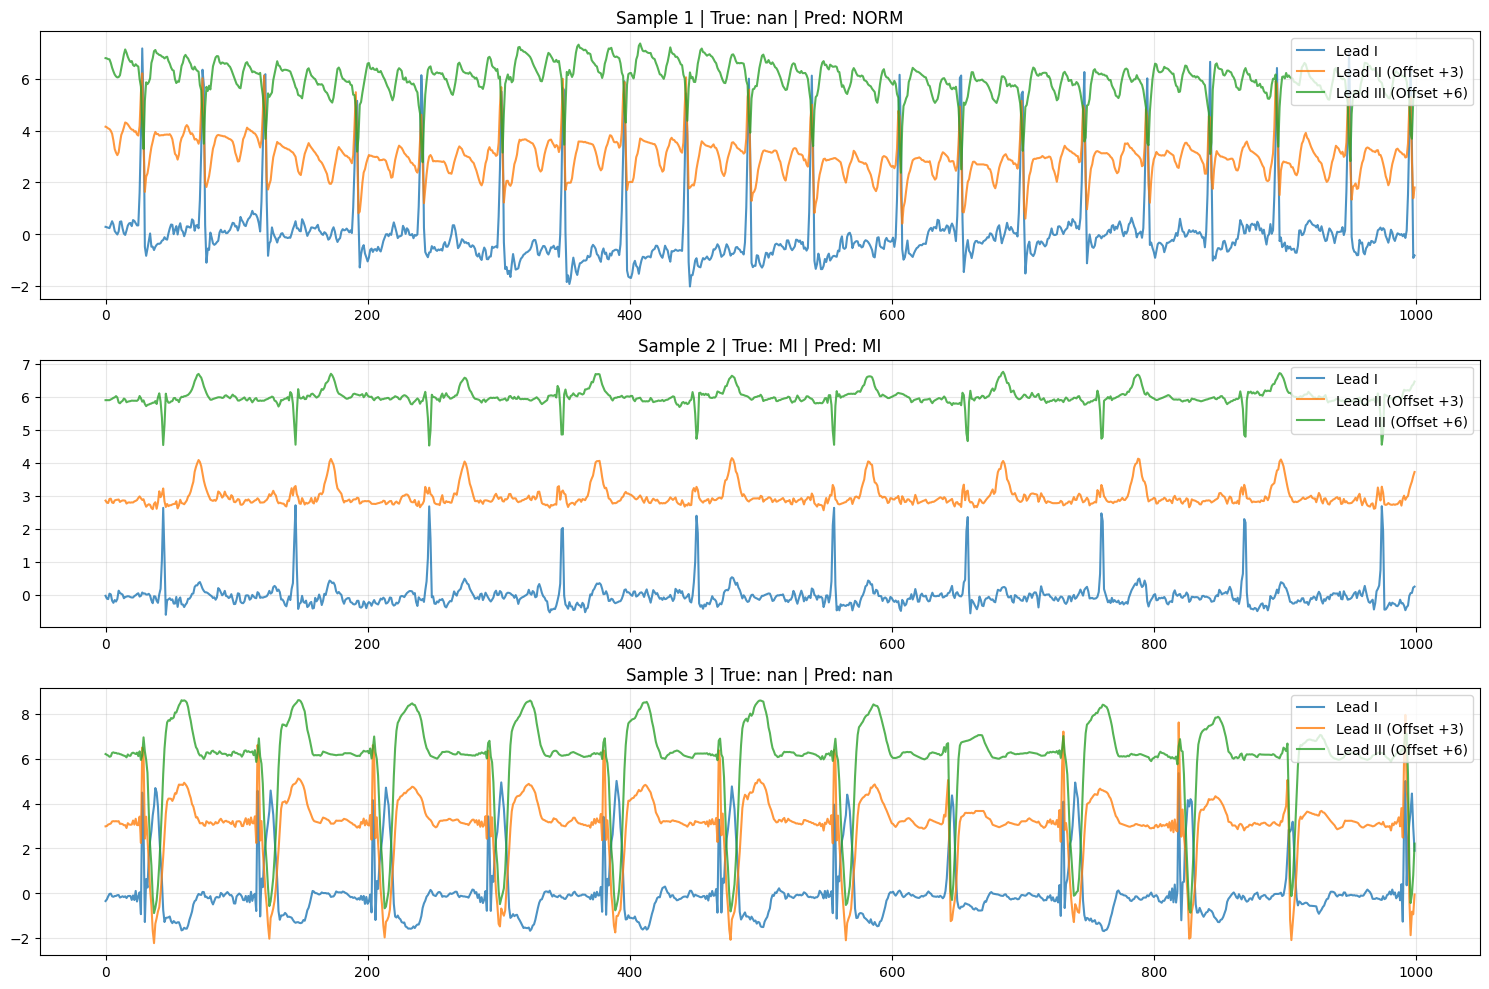

In [19]:
# @title 6. Evaluation and Visualization
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

print(f"Test Accuracy: {100. * correct / total:.2f}%")

# Visualization
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

num_samples = 3
fig, axes = plt.subplots(num_samples, 1, figsize=(15, 10))

for i in range(num_samples):
    ax = axes[i]
    ax.plot(images[i][:, 0], label='Lead I', alpha=0.8)
    ax.plot(images[i][:, 1] + 3, label='Lead II (Offset +3)', alpha=0.8)
    ax.plot(images[i][:, 2] + 6, label='Lead III (Offset +6)', alpha=0.8)
    
    true_lbl = classes[labels[i]]
    pred_lbl = classes[preds[i]]
    
    ax.set_title(f"Sample {i+1} | True: {true_lbl} | Pred: {pred_lbl}")
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()